In [1]:
import cftime
from datetime import timedelta
from datetime import datetime
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from scipy import signal

import mission_tools

%matplotlib widget

In [12]:
def extract_jump_inds(jump_inds, consecutive_values=1):
    event_inds = np.where(jump_inds == 1)[0]
    event_groups = np.split(event_inds, np.where(np.diff(event_inds) != consecutive_values)[0]+1)
    return event_groups

# Compute all jump amplitudes and times
jump_amps = []
jump_seconds = []

mission_nc_path = '../../microSWIFT_data/final_dataset/mission_19.nc'
mission_dataset = nc.Dataset(mission_nc_path, mode='r')

x_locations = np.ma.masked_invalid(mission_dataset['xFRF'])
y_locations = np.ma.masked_invalid(mission_dataset['yFRF'])
time = cftime.num2pydate(mission_dataset['time'],
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)

number_of_trajectories = x_locations.shape[0]
for trajectory_num in np.arange(number_of_trajectories):

    # Compute Cross Shore Velocity from Cross Shore Position
    cross_shore_vel = np.gradient((x_locations[trajectory_num,0] - x_locations[trajectory_num,:]), 1/12)
    cross_shore_vel = np.ma.filled(cross_shore_vel, np.NaN)
    sos = signal.butter(1, 0.1, 'lowpass', fs=12, output='sos')
    cross_shore_vel_filtered = signal.sosfilt(sos, cross_shore_vel)

    # Depth Along Trajectory
    tracjectory_bathy = mission_tools.bathy_along_track(bathy_file='../../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc', 
                                                        xFRF=x_locations[trajectory_num, :], 
                                                        yFRF=y_locations[trajectory_num, :],
                                                        single_trajectory=True)

    # Compute Linear Phase Speed at each point in track
    phase_speed_along_track = np.sqrt(np.abs(tracjectory_bathy * 9.8))[0]

    # Find all times that the cross shore velocity is higher than the threshold
    jump_threshold = phase_speed_along_track * 0.3
    jump_times = np.zeros(cross_shore_vel_filtered.size)
    jump_inds = np.where(cross_shore_vel_filtered > jump_threshold)
    jump_times[jump_inds] = 1

    # Compute Cross Shore Distance Traveled
    dist_traveled = x_locations[trajectory_num,0] - x_locations[trajectory_num,:]

    # Get the jump Indices
    jump_event_inds = extract_jump_inds(jump_times, consecutive_values=1)

    for event in jump_event_inds:
        if event.size > 0:
            jump_amps.append(dist_traveled[event[-1]] - dist_traveled[event[0]])
            jump_seconds.append((time[event[-1]] - time[event[0]]).total_seconds())

(0.0, 0.3)

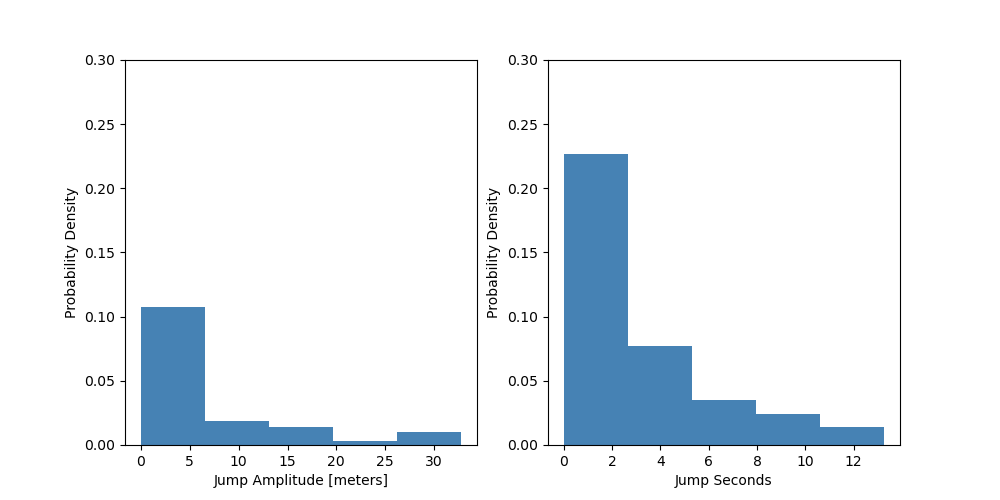

In [33]:
# Plot Histrograms of the jump events from the whole mission
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

# jump amplitudes
ax1.hist(jump_amps, bins=5, density=True, color='steelblue')
ax1.set_xlabel('Jump Amplitude [meters]')
ax1.set_ylabel('Probability Density')
ax1.set_ylim(0, 0.3)

# jump size
ax2.hist(jump_seconds, bins=5, density=True, color='steelblue')
ax2.set_xlabel('Jump Seconds')
ax2.set_ylabel('Probability Density')
ax2.set_ylim(0, 0.3)